In [1]:
#1.Запускаем сервер (эту ячейку) CTRL+ENTER
#2.В КВИКе запускаем луа-скрипт QuikLuaPython.lua
import socket
import threading
import pandas as pd

ticker = 'BRN0' #В Квике должен быть открыт стакан BRN0, а в таблице обезличенных сделок транслироваться тики BRN0
ticks=[] #Для примера, список обезличенных сделок BRN0
stakan = '' # строка формата '"имя тикера" {bid_price:bid_size,bid_price1:bid_size1...ask_price:-ask_size,ask_price1:-ask_size1}'

def parser (res):
    parse = res.split(" ", 2) #первый элемент - идентификатор события, второй имя тикера
    if parse[0] == '2': # парсинг стакана (событие '2')
        if parse[1] == ticker:
            global stakan
            stakan = parse[2]
    if parse[0] == '1': # парсинг обезличенной сделки (событие '1')
        tail = res.split(" ")
        if tail[1] == ticker: #записываем цену текущего тика BRN0 в список ticks
            ticks.append(float(tail[4]))

#Собственно сервер            
def service():
    sock=socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
    sock.bind(('127.0.0.1',3587)) #Локальный хост-этот компьютер, порт - 3587
    while True:
        res = sock.recv(2048).decode('utf-8')
        if res == '<qstp>\n':  #строка приходит от клиента при остановке луа-скрипта в КВИКе
            break
        else:
            parser(res) #Здесь вызываете свой парсер. Для примера функция: parser (parse)
    sock.close()

#Запускаем сервер в своем потоке
t = threading.Thread(name='service', target = service)
t.start()

<IPython.core.display.Javascript object>


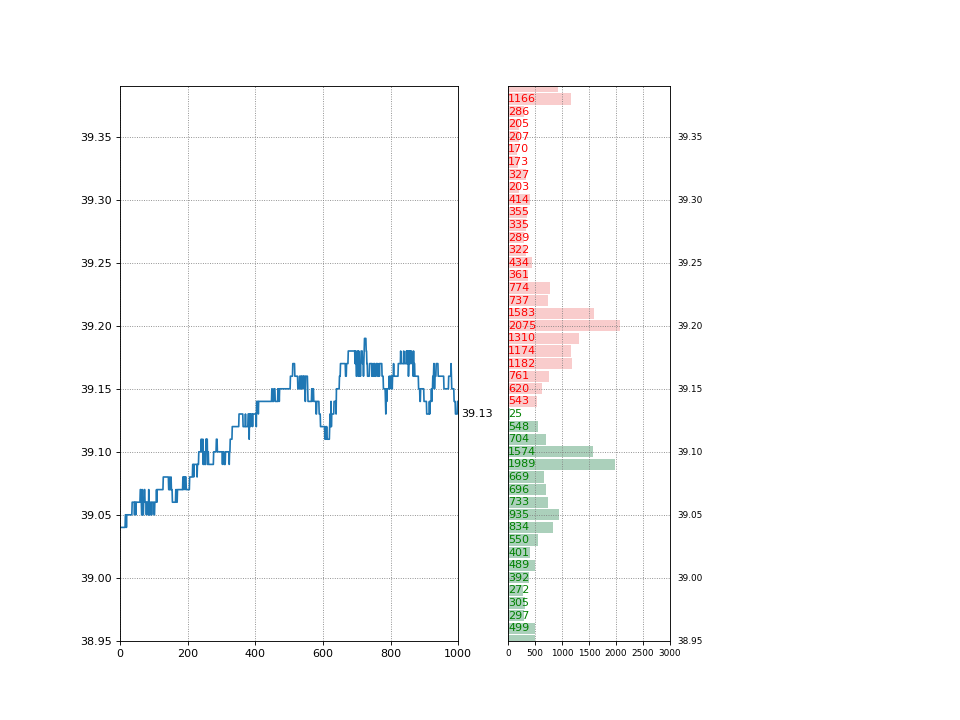

In [3]:
#3.Запускаем отображение стакана и графика тиков (эту ячейку) CTRL+ENTER
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation
%matplotlib notebook

hi_lo = [0.0, 0.45] #здесь достаточно задать верхнюю и нижнюю границу цены стакана, чтобы сохранить заданный масштаб
max_vol = 3000 #максимальное значение шкалы объема на стакане
max_ticks = 1000 #Количество отображаемых тиков на графике
fsize = 10 #размер шрифта в стакане

fig = plt.figure(figsize=(12, 9), dpi= 80) #Определяем размер изображения
ax_stakan = fig.add_subplot(1, 4, 3) #Расположение стакана
ax_tick = fig.add_subplot(1, 2, 1) #Расположение графика сделок
ax_stakan.tick_params(left = False, labelleft = False, labelright = True, labelsize=8) #Расположение осей

#Функция для автосмещения шкал при приближении текущей цены к верхней или нижней границам стакана (20 процентов)
#point - количество знаков после запятой, например для BR - 2, а для RI, SI, SR, GZ - 0, или можно не задавать
def masht(price, point = 0):
    percent = 0.2
    hi, lo = hi_lo[1], hi_lo[0]
    rn = hi - lo
    if price < lo + rn*percent or price > hi - rn*percent:
        hi_lo[0]=round(price - 0.5*rn, point)
        hi_lo[1]=round(price + 0.5*rn, point)

#Функия обновления кадра графика
def update(i):
    if ticks:
        price = ticks[-1] #Цена последней сделки
        ob_dict = eval(stakan) #читаем из строки стакан-словарь в ob_dict
        masht(price, 2) #проверяем необходимость смещения High,Low диаграммы при достижении ценой соответствующей границы
        ax_tick.clear()
        ax_stakan.clear()
        ax_tick.grid(which='major', color = 'gray', linestyle = ':')
        ax_stakan.grid(which='major', color = 'gray', linestyle = ':')

        ax_stakan.set_ylim(hi_lo)
        ax_stakan.set_xlim([0,max_vol])
        ax_tick.set_ylim(hi_lo)
        ax_tick.set_xlim([0,max_ticks])
        
        bid_price, bid_size, ask_price, ask_size = [],[],[],[]
        #Распределяем стакан-словарь на 4 списка: bid_price, bid_size, ask_price, ask_size
        for (pr, sz) in ob_dict.items():
            if pr >= hi_lo[0] and pr <= hi_lo[1]: #отображаем только объемы в видимой области стакана
                if sz > 0:
                    bid_price.append(pr)
                    bid_size.append(sz)
                else:
                    ask_price.append(pr)
                    ask_size.append(-sz)
        x, y = np.array(bid_price), np.array(bid_size)
        x1, y1 = np.array(ask_price), np.array(ask_size)
        ax_stakan.autoscale(False, tight=False) #Отключаем автошкалу Питона, чтобы график не "прыгал" постоянно
        ax_stakan.barh(x, y, height = 0.009, color = 'seagreen', alpha=0.4) #tick_label = bid_size
        ax_stakan.barh(x1, y1, height = 0.009, color = 'lightcoral', alpha=0.4)
        for (pr, sz) in zip(bid_price[1:], bid_size[1:]): #Печать объемов
            ax_stakan.text(0, pr, sz, fontsize=fsize, va='center', color='green') #darkgreen
        for (pr, sz) in zip(ask_price[:-1], ask_size[:-1]):
            ax_stakan.text(0, pr, sz, fontsize=fsize, va='center', color='red') #darkred
        #Маркер текущей цены        
        ax_tick.text(max_ticks*1.01, price, price, fontsize=10, va='center',ha='left')
        ax_tick.plot(ticks[-max_ticks:]) #Отображаем последние 1000(max_ticks) тиков

# Включаем анимацию на 1000 кадров, раз в 400 мсек
ani = matplotlib.animation.FuncAnimation(fig, update, frames=1000, repeat=False, interval=400, blit=True)
plt.show()